# Imbalance Classification

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

## Feature Engineering

In [2]:
wine= pd.read_csv('white_wine.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


In [3]:
# eda
# target data: quality, di mana quality > 6, maka good wine (1), sisanya bad wine (0)

In [4]:
wine['label']= np.where(wine['quality']>6,1,0)
wine['label'].value_counts()/wine.shape[0]*100
# bisa dilihat data kita imbalance, dengan kelas 0: kelas 1 kurang lebih 4:1

0    81.153846
1    18.846154
Name: label, dtype: float64

In [5]:
wine.isna().sum()
# feature yang dipakai adalah density dan alcohol, kita bisa mengisi missing value pada alcohol dengan fillna

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      1
sulphates               1
alcohol                 1
quality                 1
label                   0
dtype: int64

In [6]:
wine['alcohol']=wine['alcohol'].fillna(wine['alcohol'].mean())

Mari kita lihat, apakah kedua fitur yang kita pakai, alcohol dan density, mampu memisahkan good wine dari bad wine menggunakan scatter plot.

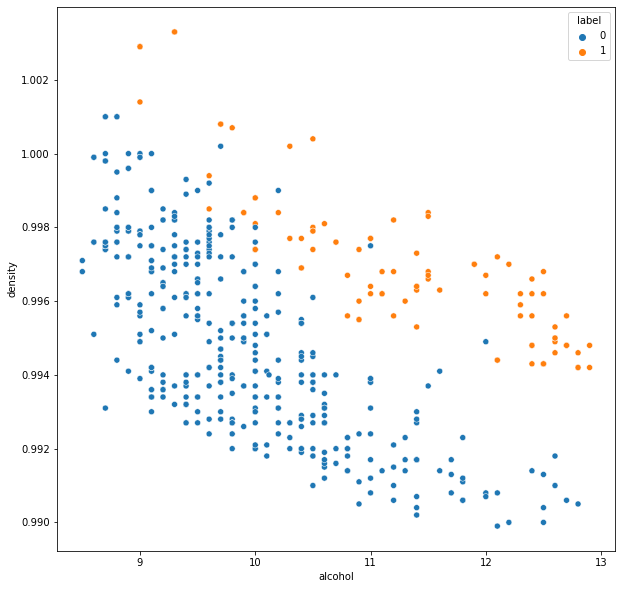

In [7]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='alcohol',y='density', data=wine, hue='label')

Secara umum, good wine memiliki nilai alkohol dan density yang lebih tinggi dibanding bad wine

In [8]:
# Splitting data
x=wine[['alcohol','density']]
y=wine['label']

In [9]:
x_train,x_test, y_train, y_test= train_test_split(x,y, stratify=y, random_state=2020)

### Model without Polynomial

In [10]:
logreg= LogisticRegression()
logreg.fit(x_train,y_train)
y_pred= logreg.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       106
           1       0.69      0.38      0.49        24

    accuracy                           0.85       130
   macro avg       0.78      0.67      0.70       130
weighted avg       0.84      0.85      0.84       130



### With Polynomial

In [11]:
poly= PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
logreg= LogisticRegression(max_iter=1000)
estimator= Pipeline([
    ('poly', poly),
    ('model',logreg)
])

In [12]:
estimator.fit(x_train,y_train)
y_pred=estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       106
           1       0.95      0.88      0.91        24

    accuracy                           0.97       130
   macro avg       0.96      0.93      0.95       130
weighted avg       0.97      0.97      0.97       130



bisa dilihat, pada kasus white wine ini, penggunaan feature engineering polynomial mampu meningkatkan performa model dari:
* precision 0.69 --> 0.95
* recall 0.38 -->0.88
* f1 score 0.49 --> 0.91
* accuracy 0.85 --> 0.97

## Resampling

In [13]:
# !pip install imblearn

In [14]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve, f1_score

from imblearn.pipeline import Pipeline # perhatikan librarynya

### Data

In [15]:
data= pd.read_csv('bankloan.csv')

### EDA

In [16]:
data['default'].value_counts()/data.shape[0]
# data imbalance, dengan perbandingkan kelas 0 dan kelas 1, 3:1

0    0.738571
1    0.261429
Name: default, dtype: float64

# Splitting data

In [17]:
x=data[['employ','debtinc','creddebt','othdebt']]
y= data['default']

In [18]:
x_train,x_test,y_train,y_test= train_test_split(x,y, stratify=y, test_size=0.2, random_state=2020)

### Model Without Treatment

In [19]:
model= LogisticRegression()
model.fit(x_train,y_train)

LogisticRegression()

In [20]:
y_pred= model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       103
           1       0.77      0.46      0.58        37

    accuracy                           0.82       140
   macro avg       0.80      0.71      0.73       140
weighted avg       0.82      0.82      0.80       140



### Model with Resampling: RandomUndersampling

In [21]:
rus= RandomUnderSampler(random_state=2020)#agar output kita sama
# undersampling tanpa pipeline
x_under, y_under=rus.fit_resample(x_train,y_train) #library imblearn memakai method resample, bukan transform

In [22]:
y_train.value_counts() # sebelum resample

0    414
1    146
Name: default, dtype: int64

In [23]:
y_under.value_counts() #setelah resample, jumlah data kelas 0 mengikuti jumlah data kelas 1

1    146
0    146
Name: default, dtype: int64

In [24]:
model_under= Pipeline([
    ('resampling',rus),
    ('model', LogisticRegression())
])

In [25]:
model_under.fit(x_train,y_train)
y_pred= model_under.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.68      0.79       103
           1       0.50      0.89      0.64        37

    accuracy                           0.74       140
   macro avg       0.72      0.79      0.72       140
weighted avg       0.83      0.74      0.75       140



Perhatikan, dengan pemakaian random undersampling pada data bankloan, maka terjadi perubahan hasil evaluasi:
* precision: 0.77 --> 0.50
* recall: 0.46 --> 0.89
* f1 score: 0.58--> 0.64 
* accuracy: 0.82 --> 0.74

kita perlu menentukan metrik evaluasi yang kita pakai di awal untuk memutuskan apakah metode ini sesuai dengan keperluan bisnis kita.

### Algorithm based: Model with Parameter Class Weight

In [26]:
model_balanced= LogisticRegression(class_weight='balanced') #untuk memberi berat lebih pada kelas minoritas
model_balanced.fit(x_train,y_train)
y_pred=model_balanced.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.68      0.78       103
           1       0.48      0.84      0.61        37

    accuracy                           0.72       140
   macro avg       0.70      0.76      0.70       140
weighted avg       0.81      0.72      0.74       140



## Summary

In [27]:
models=[model, model_under, model_balanced]
f1=[]
for i in models:
    f1.append(f1_score(y_test, i.predict(x_test)))

In [28]:
pd.DataFrame({
    'method':['benchmark','undersampling','class_weight'],
    'score':f1
})

,method,score
0,benchmark,0.576271
1,undersampling,0.640777
2,class_weight,0.613861


penggunaan metode balancing seperti resampling dan class weight mampu meningkatkan performa model (f1score). Perlu diperhatikan bahwa penggunaan metode balancing bisa menyebabkan bias, sehingga terjadi trade off antara precisiond an recall.

Di kasus bankloan, berdasarkan f1 score, maka metode balancing terbaik adalah undersampling (tapi ingat kita belum melakukan cv)

## Metric Evaluation for Imbalance Classification

In [29]:
from sklearn.metrics import SCORERS

In [30]:
SCORERS

{'explained_variance': make_scorer(explained_variance_score),
 'r2': make_scorer(r2_score),
 'max_error': make_scorer(max_error, greater_is_better=False),
 'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_absolute_percentage_error': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_squared_log_error': make_scorer(mean_squared_log_error, greater_is_better=False),
 'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
 'neg_mean_poisson_deviance': make_scorer(mean_poisson_deviance, greater_is_better=False),
 'neg_mean_gamma_deviance': make_scorer(mean_gamma_deviance, greater_is_better=False),
 'accuracy': make_scorer(accuracy_score),
 'top_k_accuracy': make_scorer(top_k_accuracy_score, ne

metrik untuk imbalance classification yang tersedia: roc_auc, balanced_accuracy, average_precision (PR-curve), neg_brier_score

In [31]:
from sklearn.metrics import fbeta_score

In [32]:
fbeta_score(y_test,y_pred,beta=2) #kalau recall 2 kali lebih penting dari precision

0.7311320754716982

In [33]:
fbeta_score(y_test,y_pred,beta=.5) #kalau precision 2 kali lebih penting dari recall

0.5290102389078498

In [34]:
# untuk membuat metric evaluasi custom
from sklearn.metrics import make_scorer

In [35]:
f2score=make_scorer(fbeta_score, beta=2)

In [36]:
f2score(model_balanced,x_test,y_test) # ini bisa masuk ke cv

0.7311320754716982

In [37]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cross_val_score(model_balanced,x_train,y_train, cv= StratifiedKFold(n_splits=5), scoring=f2score) #contoh pemakaian

array([0.70987654, 0.64516129, 0.74404762, 0.60402685, 0.70552147])

### Threshold Optimization

In [38]:
# karena cv untuk threshold optimization belum tersedia di library sklearn, kita perlu melakukan validasi manual
x_train2, x_val, y_train2, y_val= train_test_split(x_train,y_train, stratify=y_train, test_size=0.25, random_state=2020)

In [39]:
model.fit(x_train2,y_train2) #model benchmark

th_value=[i/100 for i in range (20,60)] # threshold antara 0.2-0.6
score=0
score_list=[]

for i in th_value:
    y_prob=model.predict_proba(x_val)[:,1]
    y_pred=np.where(y_prob>i,1,0)
    score_temp=f1_score(y_val,y_pred)
    score_list.append(score_temp)
    
    if score_temp>score:
        score=score_temp
        
        best_score=score
        best_th=i

C:\Users\brigi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'f1_score')

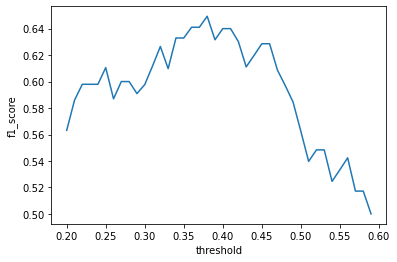

In [40]:
sns.lineplot(th_value,score_list)
plt.xlabel('threshold')
plt.ylabel('f1_score')

In [41]:
print('best score', best_score)
print('best th', best_th)

best score 0.6493506493506495
best th 0.38


In [42]:
model.fit(x_train,y_train)
y_prob=model.predict_proba(x_test)[:,1]
y_pred=np.where(y_prob>best_th,1,0)

In [43]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       103
           1       0.55      0.59      0.57        37

    accuracy                           0.76       140
   macro avg       0.70      0.71      0.70       140
weighted avg       0.77      0.76      0.77       140



In [44]:
# pr curve

In [45]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

In [46]:
model.fit(x_train2,y_train2)
y_prob_val=model.predict_proba(x_val)[:,1]
y_pred_val=model.predict(x_val)

C:\Users\brigi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


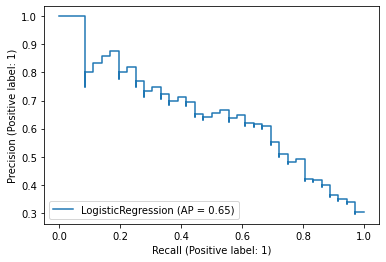

In [47]:
plot_precision_recall_curve(model, x_val,y_val)

In [48]:
p,r,th=precision_recall_curve(y_val,y_prob_val)

In [49]:
th=list(th)
th.insert(0,0)

In [50]:
pr_curve= pd.DataFrame({
    'precision':p,
    'recall': r,
    'threshold':th
})

In [51]:
pr_curve[(pr_curve['recall']>0.6)&(pr_curve['precision']>0.5)]

,precision,recall,threshold
66,0.509434,0.750000,0.280418
68,0.509804,0.722222,0.298660
69,0.520000,0.722222,0.301012
70,0.530612,0.722222,0.303087
71,0.541667,0.722222,0.314521
72,0.553191,0.722222,0.314689
73,0.543478,0.694444,0.323618
74,0.555556,0.694444,0.331693
75,0.568182,0.694444,0.333981
76,0.581395,0.694444,0.335875


In [52]:
th=pr_curve['threshold'].iloc[72] #misal kita mau recall yang cukup tinggi tapi precision tidak telalu rendah juga

In [53]:
model.fit(x_train,y_train)
y_prob=model.predict_proba(x_test)[:,1]
y_pred= np.where(y_prob>th,1,0)

In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.81       103
           1       0.51      0.68      0.58        37

    accuracy                           0.74       140
   macro avg       0.69      0.72      0.70       140
weighted avg       0.77      0.74      0.75       140



## Combining Cross Validation with Balancing Method

In [55]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline #perhatikan library-nya

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import plot_roc_curve, classification_report, f1_score

pd.set_option('display.max_columns', None) #agar semua kolom muncul

masih dengan dataset bankloan, kita bandingkan hasil resampling SMOTE dengan balancing menggunakan class_weigth

### Resampling SMOTE

In [56]:
smote=SMOTE(random_state=2020)
model=LogisticRegression(random_state=2020)
estimator=Pipeline([
    ('resampling', smote),
    ('model',model)
])

In [57]:
skfold= StratifiedKFold(n_splits=5)
model_cv=cross_val_score(estimator,x_train,y_train, cv=skfold, scoring='f1')

In [58]:
print('cv score', model_cv)
print('cv mean', model_cv.mean())
print('cv std', model_cv.std())

cv score [0.63013699 0.57575758 0.6097561  0.6031746  0.60526316]
cv mean 0.6048176841378522
cv std 0.017394499418945462


### Class Weigth

In [59]:
model=LogisticRegression(class_weight='balanced', random_state=2020)
model_cv=cross_val_score(model,x_train,y_train, cv=skfold, scoring='f1')

In [60]:
print('cv score', model_cv)
print('cv mean', model_cv.mean())
print('cv std', model_cv.std())

cv score [0.63888889 0.58823529 0.61728395 0.58064516 0.60526316]
cv mean 0.6060632905617759
cv std 0.020822978090423456


metode class weigth memiliki score sedikit lebih baik, tetapi juga sedkit lebih tidak stabil.  

untuk tahap berikutnya mari kita coba tunning model dengan SMOTE, untuk melihat bagaimana cara tunning tahapan resampling

## Hyperparameter Tunning

In [61]:
# make algorithm chain
smote= SMOTE(random_state=2020, k_neighbors=5) #default k_neighbors pada smote=5
model=LogisticRegression(random_state=2020)
estimator=Pipeline([
    ('balancing', smote),
    ('model',model)
])

In [62]:
estimator.get_params() # parameter2 pada estimator

{'memory': None,
 'steps': [('balancing', SMOTE(random_state=2020)),
  ('model', LogisticRegression(random_state=2020))],
 'verbose': False,
 'balancing': SMOTE(random_state=2020),
 'model': LogisticRegression(random_state=2020),
 'balancing__k_neighbors': 5,
 'balancing__n_jobs': None,
 'balancing__random_state': 2020,
 'balancing__sampling_strategy': 'auto',
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 100,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l2',
 'model__random_state': 2020,
 'model__solver': 'lbfgs',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [63]:
hyperparam_space= {
    'balancing__k_neighbors':[2,5,10,15,25], #default 5
    'model__C':[100,10,1,0.1,0.001,0.0001], #default 1
    'model__solver':['liblinear','newton-cg','lbfgs'],
    'model__class_weight':[None,'balanced']
}

In [64]:
grid_search= GridSearchCV(estimator,
                         param_grid=hyperparam_space,
                         cv=skfold,
                         scoring='f1',
                         n_jobs=-1)

In [65]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('balancing', SMOTE(random_state=2020)),
                                       ('model',
                                        LogisticRegression(random_state=2020))]),
             n_jobs=-1,
             param_grid={'balancing__k_neighbors': [2, 5, 10, 15, 25],
                         'model__C': [100, 10, 1, 0.1, 0.001, 0.0001],
                         'model__class_weight': [None, 'balanced'],
                         'model__solver': ['liblinear', 'newton-cg', 'lbfgs']},
             scoring='f1')

In [66]:
print('best score', grid_search.best_score_)
print('best parameter', grid_search.best_params_)

best score 0.6172614865302053
best parameter {'balancing__k_neighbors': 15, 'model__C': 0.1, 'model__class_weight': None, 'model__solver': 'newton-cg'}


### Before vs After Tunning

In [67]:
# before
smote= SMOTE(random_state=2020, k_neighbors=5) #default k_neighbors pada smote=5
model=LogisticRegression(random_state=2020)
estimator=Pipeline([
    ('balancing', smote),
    ('model',model)
])

In [68]:
estimator.fit(x_train,y_train)
y_pred=estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.70      0.80       103
           1       0.50      0.84      0.63        37

    accuracy                           0.74       140
   macro avg       0.71      0.77      0.71       140
weighted avg       0.81      0.74      0.75       140



In [69]:
# after
best_model= grid_search.best_estimator_
best_model.fit(x_train,y_train)
y_pred=best_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80       103
           1       0.50      0.81      0.62        37

    accuracy                           0.74       140
   macro avg       0.71      0.76      0.71       140
weighted avg       0.80      0.74      0.75       140



Hyperparameter malah menurunkan f1 score dari 0.63 menjadi 0.62. Bisa dicoba dengan menambah parameter lain, atau mencoba model lain

# latihan
Masih dengan data bankloan.csv:  
Pilihlah model terbaik antara:
* model decision tree (max depth 3) dengan resampling nearmiss
* model decision tree (max depth 3) dengan resampling smote  

Lakukan hyperparameter tunning pada model yang terpilih.  
tampilkan atribut dari model akhir.  

jangan lupa gunakan pipeline dan random state 2020

In [70]:
from sklearn.tree import DecisionTreeClassifier

In [71]:
model=DecisionTreeClassifier(max_depth=3, random_state=2020)
pipe_smote=Pipeline([
    ('smote',SMOTE(random_state=2020)),
    ('model',model)
])

pipe_nm=Pipeline([
    ('nearmiss',NearMiss()),
    ('model',model)
])

In [72]:
models=[pipe_smote,pipe_nm]
score=[]
rata=[]
std=[]

for i in models:
    skfold= StratifiedKFold(n_splits=5)

    model_cv=cross_val_score(i,x_train,y_train,cv=skfold,scoring='f1')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

In [73]:
pd.DataFrame({
    'bal':['smote','nearmiss'],
    'mean':rata,
    'std':std
})

,bal,mean,std
0,smote,0.549229,0.074946
1,nearmiss,0.435535,0.081567


In [74]:
hyperparam_space= {
    'smote__k_neighbors':[2,5,10,15,25],
    'model__max_depth':[1,2,3,4,5],
    'model__min_samples_split':[2,5,10,15,25,50,75,85,100,200,300],
    'model__min_samples_leaf':[1,2,5,10,15,25,50,75,100,200,300],
    'model__criterion':['entropy','gini'],
    'model__class_weight':[None,'balanced']
}

In [75]:
grid_search= GridSearchCV(pipe_smote,
                         param_grid=hyperparam_space,
                         cv=skfold,
                         scoring='f1',
                         n_jobs=-1)

In [76]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=2020)),
                                       ('model',
                                        DecisionTreeClassifier(max_depth=3,
                                                               random_state=2020))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced'],
                         'model__criterion': ['entropy', 'gini'],
                         'model__max_depth': [1, 2, 3, 4, 5],
                         'model__min_samples_leaf': [1, 2, 5, 10, 15, 25, 50,
                                                     75, 100, 200, 300],
                         'model__min_samples_split': [2, 5, 10, 15, 25, 50, 75,
                                                      85, 100, 200, 300],
                         'smote__k_neighbors': [2, 5, 10, 15, 25]},
             scoring='f1')

In [77]:
grid_search.best_params_,grid_search.best_score_ 

({'model__class_weight': None,
  'model__criterion': 'entropy',
  'model__max_depth': 5,
  'model__min_samples_leaf': 15,
  'model__min_samples_split': 50,
  'smote__k_neighbors': 2},
 0.5980846336043757)

In [78]:
pipe_smote.fit(x_train,y_train)
y_pred=pipe_smote.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.66      0.75       103
           1       0.43      0.70      0.53        37

    accuracy                           0.67       140
   macro avg       0.64      0.68      0.64       140
weighted avg       0.75      0.67      0.69       140



In [79]:
best_model= grid_search.best_estimator_
best_model.fit(x_train,y_train)
print(classification_report(y_test,best_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       103
           1       0.51      0.73      0.60        37

    accuracy                           0.74       140
   macro avg       0.70      0.74      0.71       140
weighted avg       0.79      0.74      0.75       140



In [85]:
pd.DataFrame({'impotance':best_model[1].feature_importances_}, index=x.columns)

,impotance
employ,0.387979
debtinc,0.406405
creddebt,0.205616
othdebt,0.000000
